## Prise en main de l'environnement

Dans ce notebook nous allons découvrir les différents aspects de l'environnement.
En particulier, nous allons nous familiariser avec OpenAI Gym.


## Gérer les imports

In [17]:
import gym
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from bucket_env import BucketEnv3
from bucket_env import rendering
%matplotlib inline

## Initialiser l'environnement
Pour créer l'environnement, il faut simplement créer une instance de `BucketEnv3`

In [18]:
env = BucketEnv3()

###### env.reset()
Cette méthode positionne l'environnement dans son état initial et le renvoie de manière à ce que l'agent puisse l'observer.

In [19]:
env.reset()

(0, 0, 0)

#### env.render()
Cette méthode génère une image qui représente l'état courant de l'environnement, sous la forme d'un `np.darray`

In [20]:
def displayEnv(env):
    frame = env.render(mode='rgb_array')
    plt.axis('off')
    plt.title('Env')
    plt.imshow(frame)   

Ce dossier contient les éléments nécessaires à la réalisation du projet d'apprentissage par renforcement de l'UE AAA.

Déroulé du cours
Ce module se déroule en deux temps:

La première séance est consacrée aux apports théoriques de l'apprentissage par renforcement ainsi que la prise en main de l'environnement d'étude,
La seconde séance sera consacrée à l'implémentation d'algorithmes de RL.
Préparation de l'environnement de travail
Votre travail se fera sur des Notebooks Jupyter, en utilisant différentes packages Python.

Il va donc être nécessaire d'avoir une version récente de Python et de pip, le gestionnaire de paquet.

Vous pouvez suivre les instructions suivantes pour installer l'un ou l'autre:

Installer la dernière version de Python 
Installer pip
Une fois Python et pip installés, vous devez executer la ligne suivante dans un terminal:

    pip install matplotlib numpy tqdm jupyter gym==0.21.0

Ensuite, vous devez télécharger l'archive nommée ProjetRL2022.zip et la décompresser dans le dossier de votre choix.

Puis, ouvrez un terminal et rendez vous dans le dossier nouvellement créé et lancez la commande suivante:

    jupyter notebook

Une nouvelle fenêtre de votre navigateur s'ouvre affichant le contenu du dossier.

#### env.step()
Cette méthode applique une action choisie par l'agent dans l'environnement, pour le modifier. En réponse, l'environnement renvoie un tuple de quatre objets:
- l'état suivant,
- la récompense obtenue,
- (bool) si la tâche est accomplie
- n'importe quelles autres informations pertinentes dans un dictionnaire 

In [21]:
env.reset()
action = np.random.choice(5)
env.step(action)

((2, 0, 0), 1.0, False, {})

###### Afficher le nouvel état

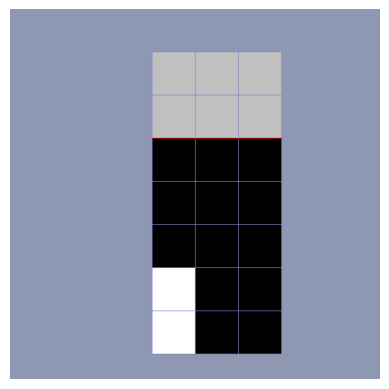

In [22]:
frame = env.render()
plt.axis('off')
plt.imshow(frame)

#### env.close()
Cela termine la tâche et ferme l'environnement, libérant les ressources.

In [23]:
env.close()

## L'environnement Bucket : placer des colis

Dans cette section, nous allons nous familiariser avec l'environnement que nous allons utiliser. Cet environnement est pratique pour apprendre les bases de l'apprentissage par renforcement parce que:
- il offre peu d'actions (5)
- les transitions entre les états sont déterministes ($p(s', r| s, a) = 1$)
- les récompenses sont proportionnelles au nombre de colis placés
- l'espace des états est relativement faible ($7^3 = 343$)

Nous allons pouvoir utiliser les concepts suivants:
- états et espace d'états
- actions et espace d'actions
- trajectoires et épisodes
- récompenses et gains
- politique

Cet environnement représente un carton de 3 x 5 (l x h), dans lequel le but de l'agent est de placer le plus de colis possible. 

Tous les colis sont identiques: un rectangle de dimension (l x h): 1 x 2.
L'orientation d'un colis se fait par rapport à un cube de référence.
Ce colis dispose de deux orientations possibles:
- 0 : (l x h): 1 x 2, le cube de référence est en (0,0),
- 1: (l x h): 2 x 1, le cube de référence est en (0,0).

L'objectif est de placer 7 colis dans le carton.


#### Création de l'environnement

In [24]:
env = BucketEnv3()

#### Etats et espace des états
Le fond du carton est discrétisé en 15 cellules, pouvant prendre des valeurs dans l'intervalle [0,1]. La valeur d'une cellule représente son occupation par un colis.

Un état est un tuple de 3 valeurs comprises dans l'intervalle [0,6] (mais seules les valeurs < 5 sont intéressantes).

L'espace d'états est faible : $7^{3} = 343$, et en pratique, certains états ne sont jamais atteignables.
En effet, il est considéré que les colis ne *volent* pas et repose forcément sur le fond du carton ou un autre colis (même partiellement). 

Les informations relatives à l'espace des états sont stockées dans `env.observation_space` qui est une instance de `MultiDiscrete([7 7 7])`. Cela indique qu'elle est composé de 3 éléments (les colonnes), chacun pouvant prendre 7 valeurs différentes.

In [25]:
env.observation_space

MultiDiscrete([7 7 7])

#### Actions et espace des actions
Dans cet environnement, il y a 5 actions différentes, elle sont représentées par un entier:

\begin{equation}
a \in \{0, 1, 2, 3, 4\}
\end{equation}

- 0 -> colis dans l'orientation 0 avec x = 0
- 1 -> colis dans l'orientation 0 avec x = 1
- 2 -> colis dans l'orientation 0 avec x = 2
- 3 -> colis dans l'orientation 1 avec x = 0
- 4 -> colis dans l'orientation 1 avec x = 1

Pour éxécuter une action, il suffit de passer l'entier correspondant à la méthode `env.step`.

Les informations relatives à l'espace des actions sont stockées dans env.action_space qui est une instance de Discrete(5). Cela indique qu'elle définit l'intervalle [0,4].

#### Trajectoires et épisodes
Une trajectoire est une séquence générée en passant d'un état à un autre:

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_N, S_N,
\end{equation}

Par exemple, voici une trajectoire de 3 actions prises aléatoirement:

La trajectoire est : [[(0, 0, 0), 1, 1.0, (0, 2, 0)], [(0, 2, 0), 1, 1.0, (0, 4, 0)], [(0, 4, 0), 2, 1.0, (0, 4, 2)]]


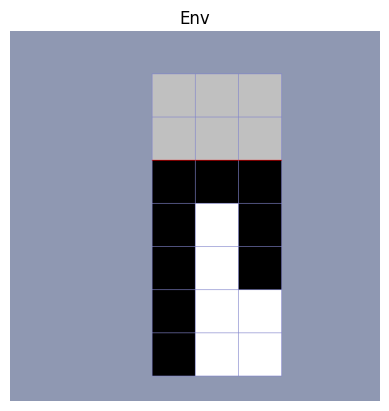

In [26]:
state = env.reset()
trajectory = []
for _ in range(3):
    action = np.random.choice(5)
    next_state, reward, done, _ = env.step(action)
    trajectory.append([state,action,reward,next_state])
    state = next_state
print(f'La trajectoire est : {trajectory}')
displayEnv(env)

Un épisode est une trajectoire qui part de l'état initial et atteint un état final:

\begin{equation}
  \tau = S_0, A_0, R_1, S_1, A_1, ... R_T, S_T,
\end{equation}
où T est un état final.

Par exemple, voici un épisode entier:

[[(0, 0, 0), 2, 1.0, (0, 0, 2)], [(0, 0, 2), 1, 1.0, (0, 2, 2)], [(0, 2, 2), 0, 1.0, (2, 2, 2)], [(2, 2, 2), 0, 1.0, (4, 2, 2)], [(4, 2, 2), 1, 1.0, (4, 4, 2)], [(4, 4, 2), 1, 0.0, (4, 5, 2)]]


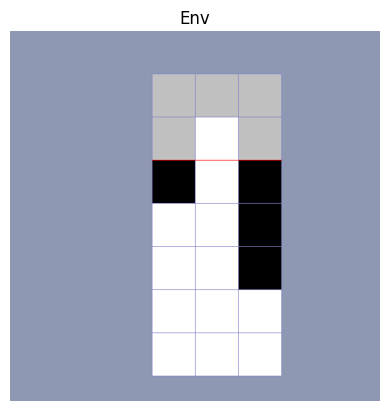

In [27]:
state = env.reset()
episode = []
done = False
while not done:
    action = np.random.choice(5)
    next_state, reward, done, _ = env.step(action)
    episode.append([state,action,reward,next_state])
    state = next_state
print(episode)
displayEnv(env)

#### Récompenses et gains
Une récompense est un valeur numérique renvoyé par l'environnement apès l'application d'une action *a* prise par l'agent dans l'état *s*:

\begin{equation}
    r = r(s, a)
\end{equation}

Par exemple, voici une récompense obtenue: 

In [28]:
env.reset()
_, reward, _, _ = env.step(1)
print(reward)

1.0


Le gain associé au temps *t* est la somme (pondérées) des récompenses que l'agent a obtenu jusqu'à ce moment.
Il est possible de calculer $G_0$, c'est-à-dire le gain au début de l'épisode:


\begin{equation}
    G_0 = R_1 + \gamma R_2 + \gamma^2 R_3 + ... + \gamma^{T-1} R_T
\end{equation}

En considérant un facteur de *rabais* $\gamma = 0.99$:

In [29]:
state = env.reset()

G = 0
gamma = 0.99
done = False
t = 0 

while not done:
    action = np.random.choice(5)
    next_state, reward, done, _ = env.step(action)
    G += reward * gamma ** t
    t += 1
print(f'Le gain obtenu est {G}')

Le gain obtenu est 3.940399


##### Politique

Une politique est une fonction $\pi(a|s) \in [0, 1]$ qui donne la probabilité d'une action depuis l'état courant.
Cette fonction prend en argument un état et une action et retourne une valeur dans [0.,1.].


En pratique, nous avons de calculer la probabilités de toutes les actions, nous représenterons une politique comme une fonction qui prend un état en argumene et renvoie les probabilités associées à chaque action.
Donc, si les probabilités sont:
    
[0.5, 0.3, 0.2]

l'action à l'indice 0 a 50% de probabiltés d'être choisie, celle à l'indice 1 est à 30% et la dernière à 20%.



Nous pouvons définir une politique qui choisit les actions aléatoirement:

In [30]:
def random_policy(state):
    return np.array([1/5] * 5)
print(random_policy(env.reset()))

[0.2 0.2 0.2 0.2 0.2]


## Appliquons cette politique sur un épisode


#### Créer et ré-initialiser l'environnement


In [31]:
env = BucketEnv3()
env.reset()

(0, 0, 0)

###### Calculer $p(a|s) \; \forall a \in \{0, 1, 2, 3, 4\}$

#### Utilisons cette politique au cours d'un épisode